In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.python.ops.numpy_ops import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
np.random.seed(32)

2021-10-15 13:08:44.688819: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [4]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/topic-modeling-for-research-articles/sample_sub.csv
/kaggle/input/topic-modeling-for-research-articles/Train.csv
/kaggle/input/topic-modeling-for-research-articles/Test.csv
/kaggle/input/topic-modeling-for-research-articles/Tags.csv


In [5]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


In [6]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [7]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


### Let's check 1st file: /kaggle/input/Tags.csv

In [8]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Tags.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('/kaggle/input/topic-modeling-for-research-articles/Tags.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'Tags.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 25 rows and 1 columns


Let's take a quick look at what the data looks like:

In [9]:
df1.head(5)

,Tags
0,Analysis of PDEs
1,Applications
2,Artificial Intelligence
3,Astrophysics of Galaxies
4,Computation and Language


Distribution graphs (histogram/bar graph) of sampled columns:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


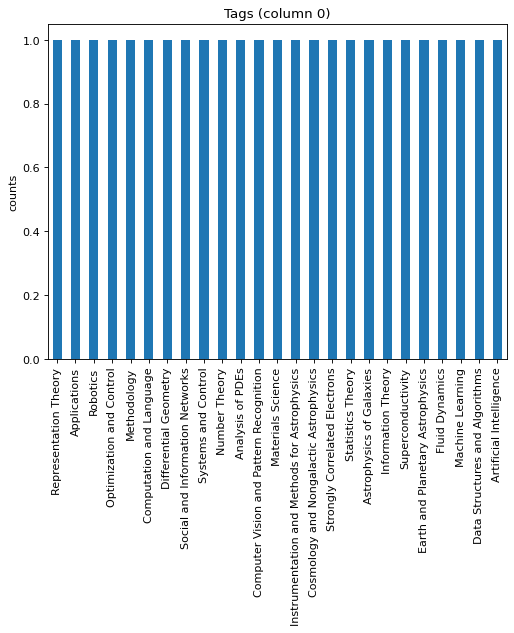

In [10]:
plotPerColumnDistribution(df1, 10, 5)

### Let's check 2nd file: /kaggle/input/Test.csv

In [11]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Test.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df2 = pd.read_csv('/kaggle/input/topic-modeling-for-research-articles/Test.csv', delimiter=',', nrows = nRowsRead)
df2.dataframeName = 'Test.csv'
nRow, nCol = df2.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 6 columns


Let's take a quick look at what the data looks like:

In [12]:
df2

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0
3,16870,we construct finite time blow-up solutions to ...,0,1,0,0
4,10496,planetary nebulae (pne) constitute an importan...,0,0,1,0
...,...,...,...,...,...,...
995,18895,we present spectra of 5 ultra-diffuse galaxies...,0,0,1,0
996,8310,we present the new deep meta reinforcement lea...,1,0,0,1
997,1292,"inside this paper, a stability of fractional d...",1,0,0,0
998,17011,we address a problem of modeling and predictio...,1,0,0,0


Distribution graphs (histogram/bar graph) of sampled columns:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


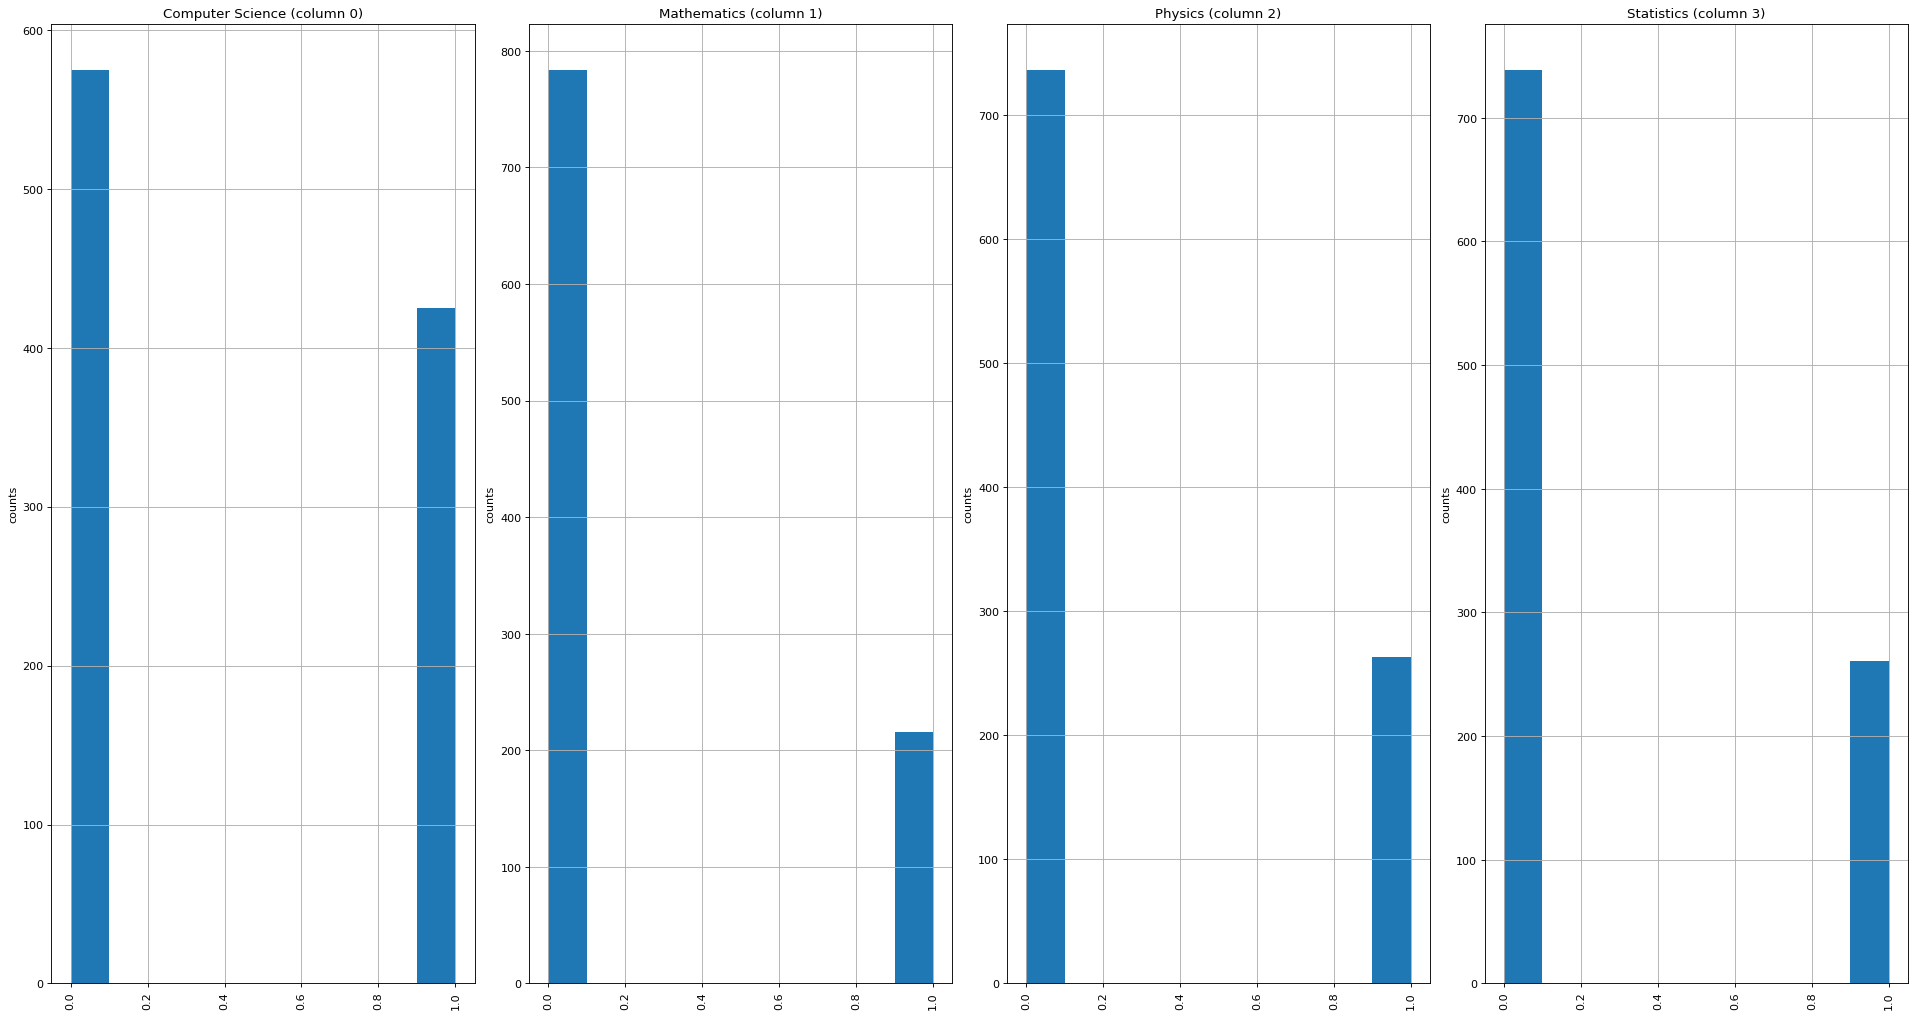

In [13]:
plotPerColumnDistribution(df2, 10, 5)

Correlation matrix:

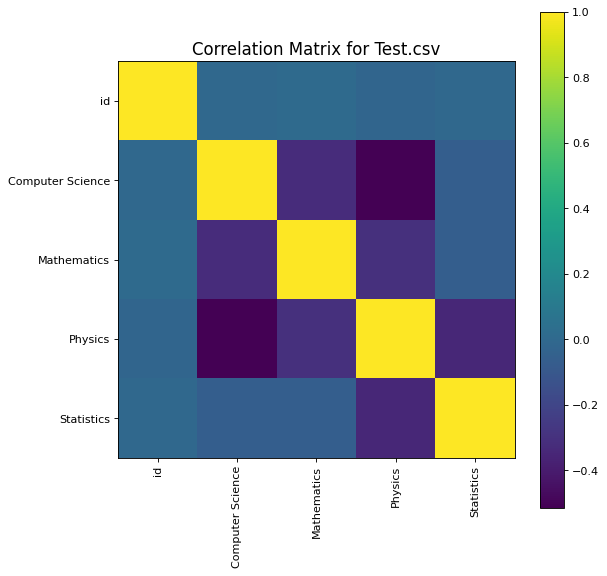

In [14]:
plotCorrelationMatrix(df2, 8)

Scatter and density plots:

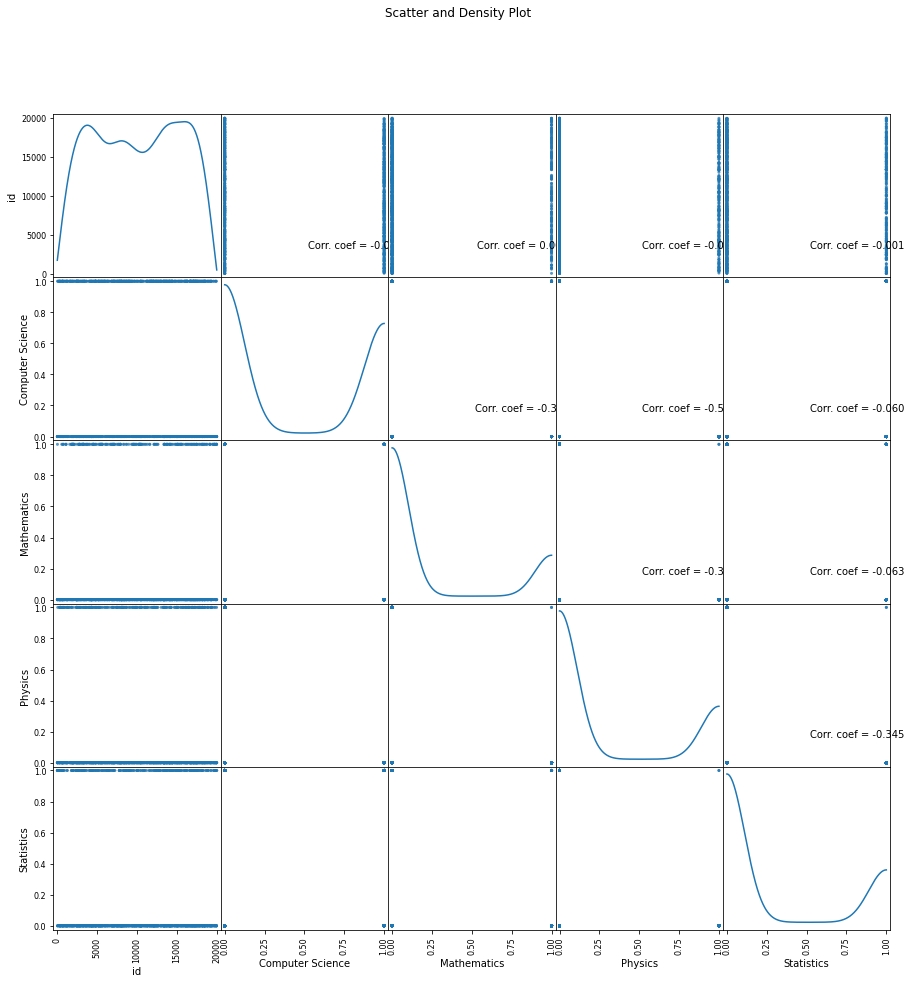

In [15]:
plotScatterMatrix(df2, 15, 10)

### Let's check 3rd file: /kaggle/input/Train.csv

In [16]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# Train.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('/kaggle/input/topic-modeling-for-research-articles/Train.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'Train.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 31 columns


Let's take a quick look at what the data looks like:

In [17]:
df3.head(5)

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Distribution graphs (histogram/bar graph) of sampled columns:

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


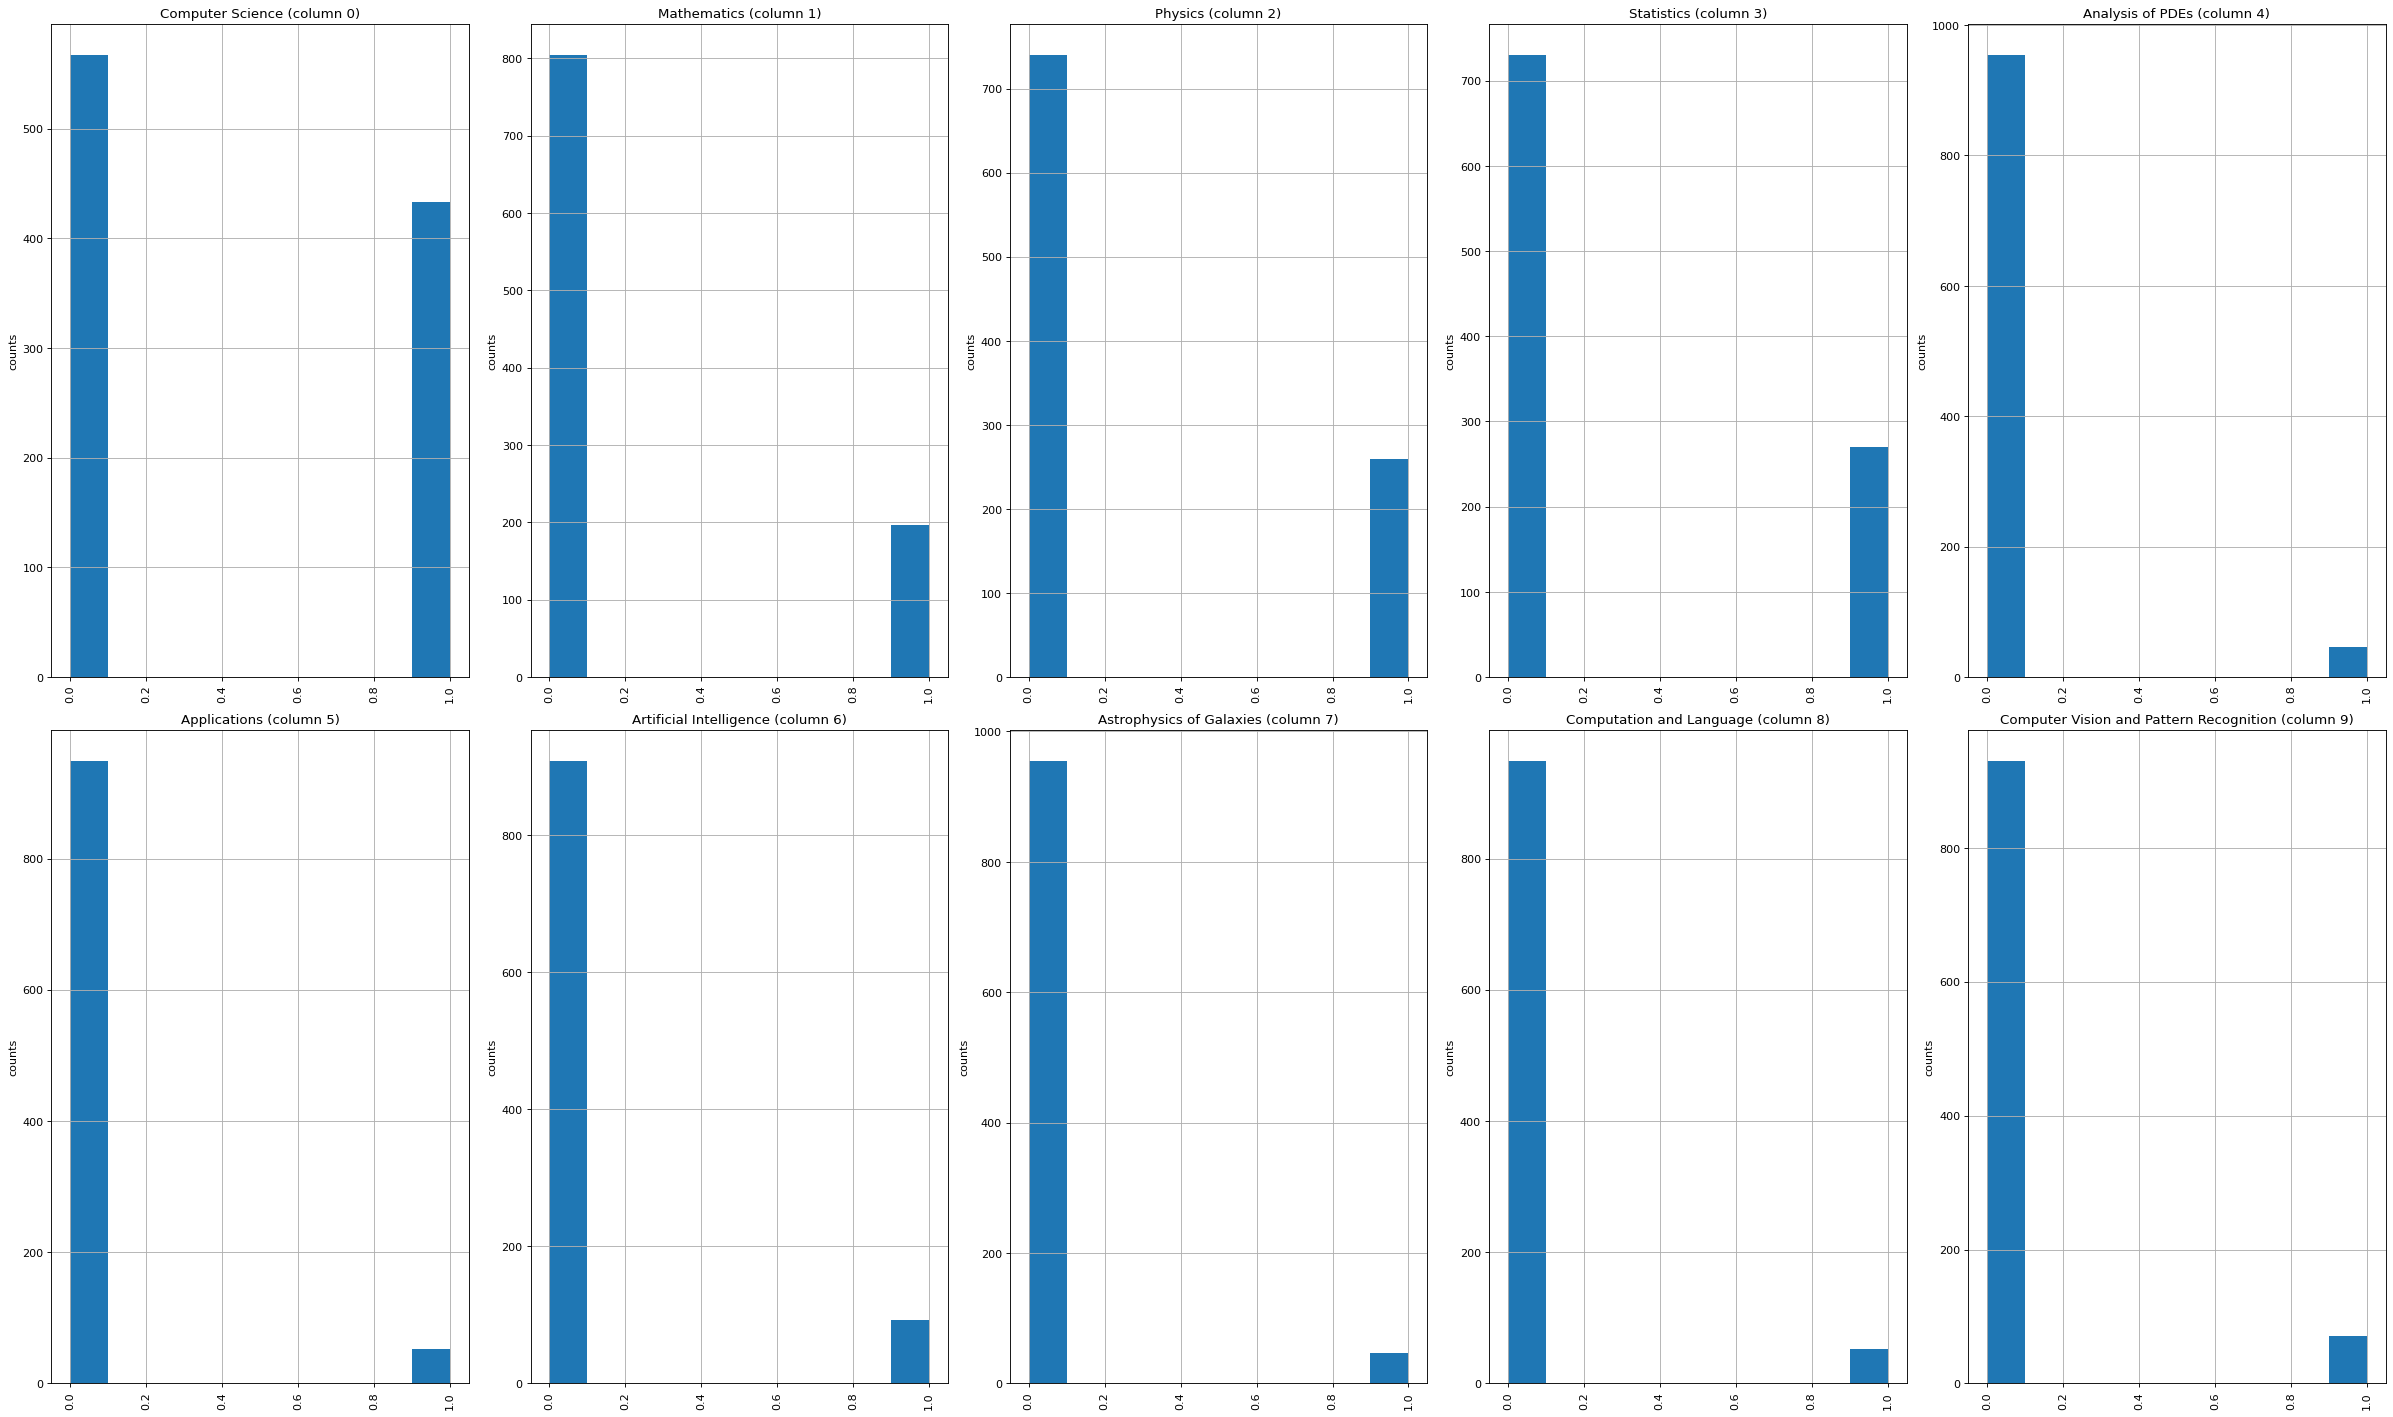

In [18]:
plotPerColumnDistribution(df3, 10, 5)

Correlation matrix:

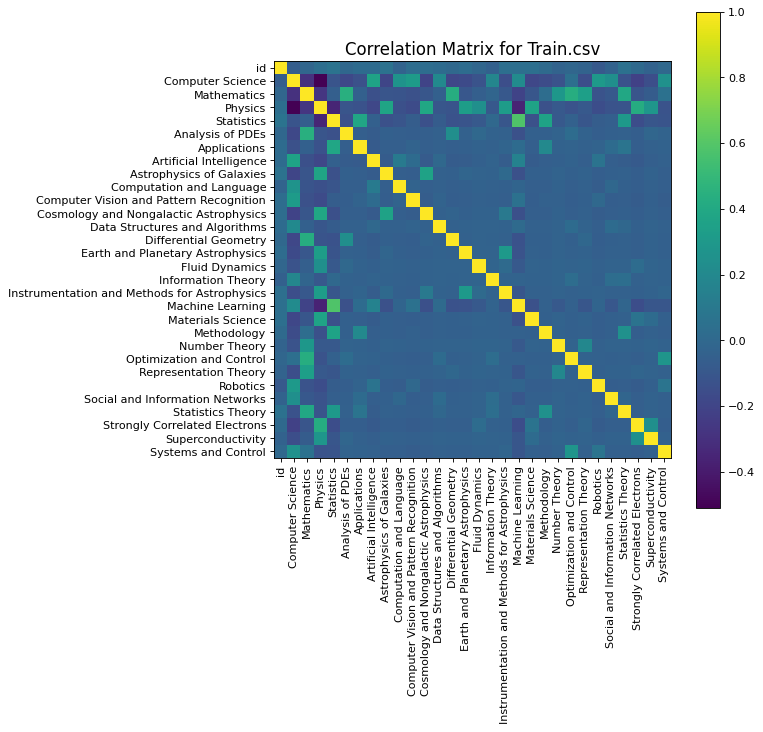

In [19]:
plotCorrelationMatrix(df3, 8)

Scatter and density plots:

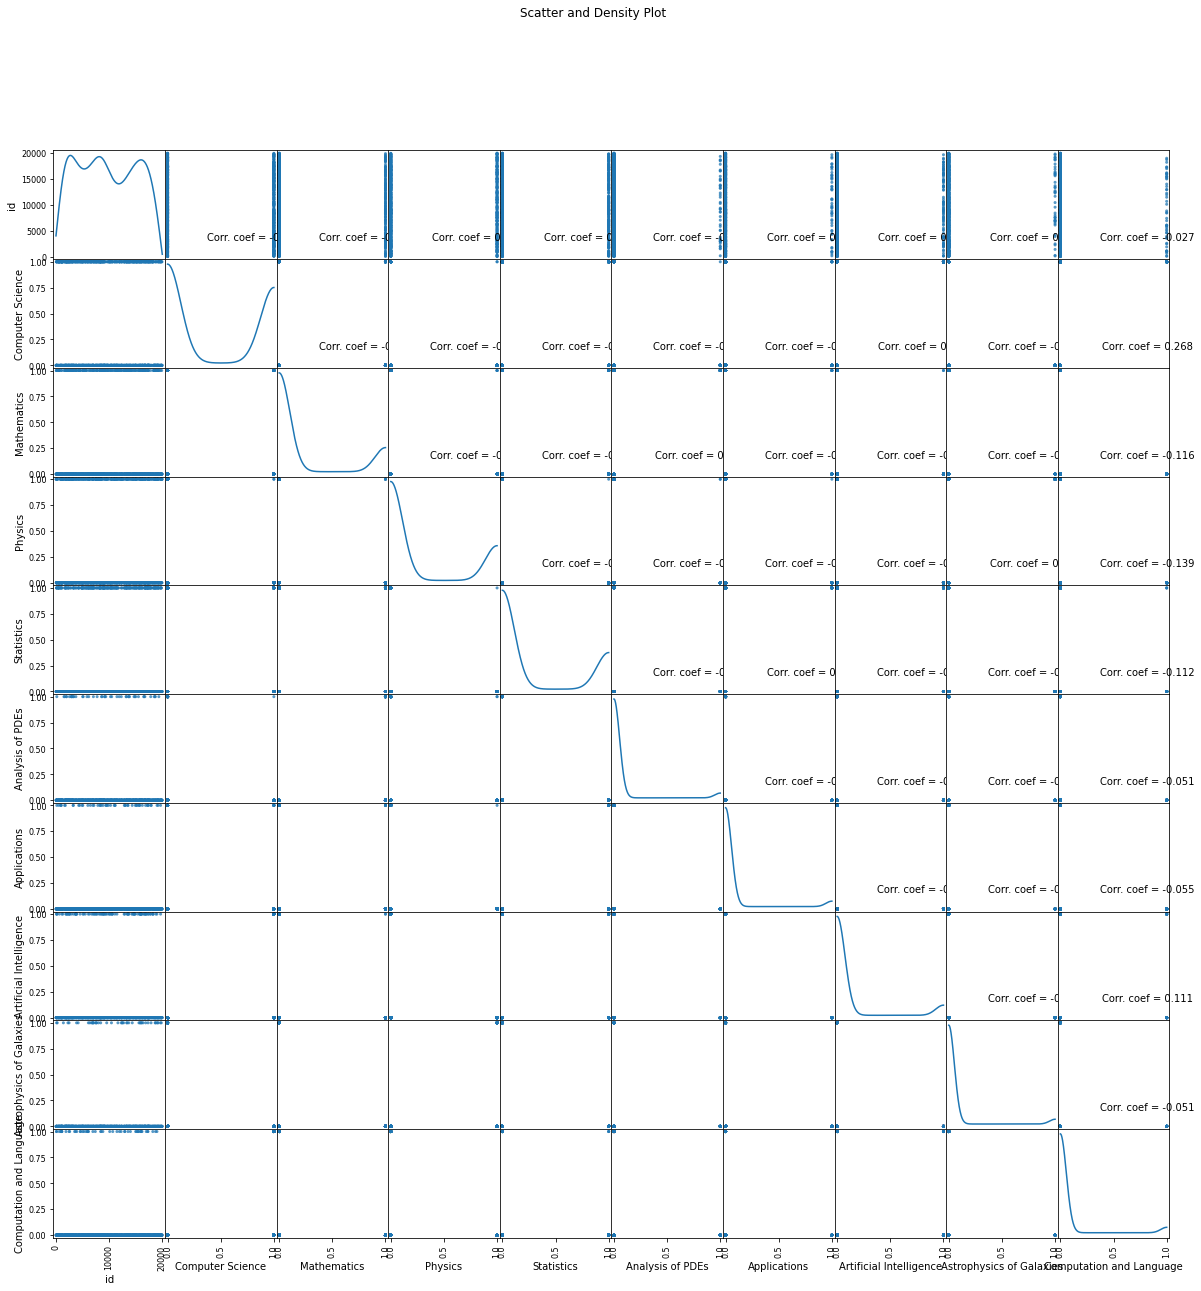

In [20]:
plotScatterMatrix(df3, 20, 10)

In [21]:
for col in df3.columns:
    print(col)

id
ABSTRACT
Computer Science
Mathematics
Physics
Statistics
Analysis of PDEs
Applications
Artificial Intelligence
Astrophysics of Galaxies
Computation and Language
Computer Vision and Pattern Recognition
Cosmology and Nongalactic Astrophysics
Data Structures and Algorithms
Differential Geometry
Earth and Planetary Astrophysics
Fluid Dynamics
Information Theory
Instrumentation and Methods for Astrophysics
Machine Learning
Materials Science
Methodology
Number Theory
Optimization and Control
Representation Theory
Robotics
Social and Information Networks
Statistics Theory
Strongly Correlated Electrons
Superconductivity
Systems and Control


In [22]:
df3.isnull().sum()

id                                              0
ABSTRACT                                        0
Computer Science                                0
Mathematics                                     0
Physics                                         0
Statistics                                      0
Analysis of PDEs                                0
Applications                                    0
Artificial Intelligence                         0
Astrophysics of Galaxies                        0
Computation and Language                        0
Computer Vision and Pattern Recognition         0
Cosmology and Nongalactic Astrophysics          0
Data Structures and Algorithms                  0
Differential Geometry                           0
Earth and Planetary Astrophysics                0
Fluid Dynamics                                  0
Information Theory                              0
Instrumentation and Methods for Astrophysics    0
Machine Learning                                0


In [23]:
df3.isnull().values.any()

False

In [24]:
train_text = df3['ABSTRACT']
train_y = df3.loc[:, df3.columns != 'ABSTRACT'].loc[:, df3.loc[:, df3.columns != 'ABSTRACT'].columns != 'id']

test_text = df2['ABSTRACT']
test_y = df2.loc[:, df2.columns != 'ABSTRACT'].loc[:, df2.loc[:, df2.columns != 'ABSTRACT'].columns != 'id']


In [25]:
train_text.shape

(1000,)

In [26]:
MAX_NB_WORDS = 20000

# get the raw text data
texts_train = train_text.astype(str)
texts_test = test_text.astype(str)

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, char_level=False)
tokenizer.fit_on_texts(texts_train)
sequences = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/text.py:180: UserWarning: The `nb_words` argument in `Tokenizer` has been renamed `num_words`.
  warnings.warn('The `nb_words` argument in `Tokenizer` '


Found 12003 unique tokens.


In [27]:
sequences[0]

[1,
 2693,
 2100,
 186,
 6,
 1305,
 2694,
 49,
 5619,
 7360,
 6,
 146,
 961,
 245,
 17,
 260,
 4,
 1306,
 23,
 1095,
 4,
 2285,
 146,
 755,
 49,
 101,
 564,
 5,
 7361,
 13,
 928,
 109,
 156,
 1532,
 470,
 12,
 7362,
 1,
 1959,
 200,
 34,
 470,
 12,
 4538,
 414,
 231,
 4539,
 6,
 3,
 4540,
 361,
 6,
 13,
 42,
 7,
 261,
 3372,
 3,
 2469,
 2285,
 3373,
 11,
 2470,
 1,
 859,
 50,
 200,
 4,
 4539,
 144,
 17,
 1306,
 550,
 2,
 1,
 1200,
 512,
 3372,
 7363,
 1960,
 23,
 83,
 3,
 2986,
 897,
 7364,
 10,
 3,
 33,
 2,
 1,
 723,
 317,
 4,
 2471,
 2,
 92,
 277,
 6,
 1,
 1960,
 1,
 3878,
 405,
 6,
 1,
 550,
 14,
 461,
 1306,
 4,
 7365,
 962,
 5,
 427,
 6,
 1,
 200,
 31,
 405,
 20,
 21,
 7366,
 15,
 34,
 5620,
 15,
 70,
 122,
 38,
 16,
 462,
 4,
 724,
 156,
 39,
 20,
 21,
 580,
 1245,
 10,
 3,
 33,
 2,
 3,
 1626,
 302,
 1146,
 9,
 250,
 66,
 10,
 3,
 33,
 2,
 303,
 2469,
 139,
 19,
 229,
 3,
 5621,
 5622,
 421,
 3372,
 353,
 2986,
 3879,
 5,
 21,
 7367,
 2472,
 12,
 1047,
 2,
 1,
 1200,
 550,
 7,
 4

In [28]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 12003)

In [29]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())

In [30]:
" ".join([index_to_word[i] for i in sequences[0]])

'a ever growing datasets inside observational astronomy have challenged scientists inside many aspects including an efficient and interactive data exploration and visualization many tools have been developed to confront this challenge however they usually focus on displaying a actual images or focus on visualizing patterns within catalogs inside the predefined way inside this paper we introduce vizic the python visualization library that builds a connection between images and catalogs through an interactive map of a sky region vizic visualizes catalog data over the custom background canvas with the help of a shape size and orientation of each object inside a catalog a displayed objects inside a map are highly interactive and customizable comparing to those inside a images these objects should be filtered by or colored by their properties such as redshift and magnitude they also should be sub selected with the help of the lasso like tool considering further analysis with the help of sta

In [31]:
" ".join([index_to_word[i] for i in sequences[1]])

"we propose the framework considering optimal t matchings excluding a prescribed t factors inside bipartite graphs a proposed framework was the generalization of a nonbipartite matching problem and includes several problems such as a triangle free 2 matching square free 2 matching even factor and arborescence problems inside this paper we demonstrate the unified understanding of these problems by commonly extending previous important results we solve our problem under the reasonable assumption which was sufficiently broad to include a specific problems listed above we first present the min max theorem and the combinatorial algorithm considering a unweighted version we then provide the linear programming formulation with dual integrality and the primal dual algorithm considering a weighted version the key ingredient of a proposed algorithm was the technique to shrink forbidden structures which corresponds to a techniques of shrinking odd cycles triangles squares and directed cycles insi

In [32]:
seq_lens = [len(s) for s in sequences]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 168.0
max length: 346


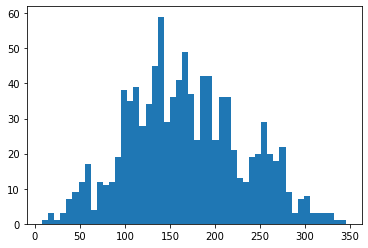

In [33]:
plt.hist(seq_lens, bins=50);

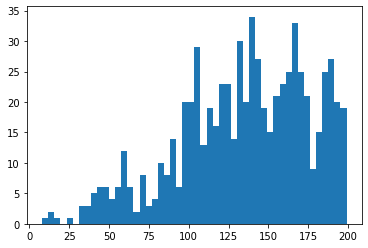

In [34]:
plt.hist([l for l in seq_lens if l < 200], bins=50);

In [35]:
MAX_SEQUENCE_LENGTH = 150

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', x_train.shape)
print('Shape of data test tensor:', x_test.shape)


Shape of data tensor: (1000, 150)
Shape of data test tensor: (1000, 150)


In [36]:
y_train = train_y
y_test = test_y

y_train = np.asarray(y_train)
print('Shape of label tensor:', y_train.shape)

y_test = np.asarray(y_test)
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (1000, 29)
Shape of label tensor: (1000, 4)


In [37]:
y_train = train_y
y_test = test_y
y_train = np.asarray(y_train)
y_train_new = np.array([])
"""for i in range(len(y_train)):
    y_train_new  (np.delete(y_train[i],[0,1,2,3]))
y_train = np.asarray(y_train_new)"""
print('Shape of label tensor:', y_train.shape)

y_test = np.asarray(y_test)
print('Shape of label tensor:', y_test.shape)

Shape of label tensor: (1000, 29)
Shape of label tensor: (1000, 4)


CNN

In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

y_train=y_train
import numpy as np
model = Sequential()
model.add(layers.Dense(10, input_dim=150,activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(29, activation='softmax'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


model.fit(x_train, y_train,epochs=25,batch_size=15)

2021-10-15 13:09:06.363083: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-15 13:09:06.366413: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-10-15 13:09:06.408192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-15 13:09:06.408862: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-10-15 13:09:06.408923: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-10-15 13:09:06.430430: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1510      
_________________________________________________________________
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                176       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 29)                493       
Total params: 2,451
Trainable params: 2,451
Non-trainable params: 0
______________________________________________________

2021-10-15 13:09:08.268865: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-15 13:09:08.280497: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz
2021-10-15 13:09:08.809353: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11


24/67 [=========>....................] - ETA: 0s - loss: 283.3096 - accuracy: 0.0455

2021-10-15 13:09:09.673032: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


67/67 [==============================] - 2s 4ms/step - loss: 198.3767 - accuracy: 0.0342
Epoch 2/25
67/67 [==============================] - 0s 3ms/step - loss: 21.3013 - accuracy: 0.0153
Epoch 3/25
67/67 [==============================] - 0s 3ms/step - loss: 8.5856 - accuracy: 0.0078
Epoch 4/25
67/67 [==============================] - 0s 2ms/step - loss: 3.8491 - accuracy: 0.0111
Epoch 5/25
67/67 [==============================] - 0s 3ms/step - loss: 4.0142 - accuracy: 0.0020
Epoch 6/25
67/67 [==============================] - 0s 2ms/step - loss: 2.8061 - accuracy: 0.0028
Epoch 7/25
67/67 [==============================] - 0s 2ms/step - loss: 1.6108 - accuracy: 0.0027
Epoch 8/25
67/67 [==============================] - 0s 3ms/step - loss: 1.2888 - accuracy: 0.0191
Epoch 9/25
67/67 [==============================] - 0s 2ms/step - loss: 1.0380 - accuracy: 0.0905
Epoch 10/25
67/67 [==============================] - 0s 2ms/step - loss: 0.9862 - accuracy: 0.1379
Epoch 11/25
67/67 [========

In [43]:
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Embedding, BatchNormalization, Flatten
vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
model.add(Embedding(vocab_size, 128, input_length=150))
model.add(Conv1D(128, 8, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Conv1D(64, 8, activation='relu'))
model.add(Dropout(0.6))
model.add(BatchNormalization())
model.add(Conv1D(32, 8, activation='relu'))
model.add(Dropout(0.7))
model.add(BatchNormalization())
model.add(MaxPooling1D())
model.add(Flatten())
model.add(layers.Dense(29, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.fit(x_train, y=y_train, batch_size=128,epochs=40, verbose=1)

Epoch 1/40
8/8 [==============================] - 2s 36ms/step - loss: 11.6276 - accuracy: 0.0805
Epoch 2/40
8/8 [==============================] - 0s 47ms/step - loss: 10.7471 - accuracy: 0.2673
Epoch 3/40
8/8 [==============================] - 0s 40ms/step - loss: 11.4211 - accuracy: 0.2903
Epoch 4/40
8/8 [==============================] - 0s 38ms/step - loss: 11.8978 - accuracy: 0.3169
Epoch 5/40
8/8 [==============================] - 0s 33ms/step - loss: 12.2289 - accuracy: 0.3512
Epoch 6/40
8/8 [==============================] - 0s 34ms/step - loss: 12.9281 - accuracy: 0.3035
Epoch 7/40
8/8 [==============================] - 0s 33ms/step - loss: 12.4124 - accuracy: 0.3250
Epoch 8/40
8/8 [==============================] - 0s 34ms/step - loss: 13.8795 - accuracy: 0.2786
Epoch 9/40
8/8 [==============================] - 0s 32ms/step - loss: 16.4519 - accuracy: 0.2856
Epoch 10/40
8/8 [==============================] - 0s 34ms/step - loss: 20.6331 - accuracy: 0.2220
Epoch 11/40
8/8 [==

In [39]:
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

In [40]:
import tokenization
import tensorflow as tf
import tensorflow_hub as hub
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)

In [41]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
        
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len-len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
        
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [42]:
def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    clf_output = sequence_output[:, 0, :]
    
    lay = tf.keras.layers.Dense(1024, activation='relu')(clf_output)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    lay = tf.keras.layers.Dense(521, activation='relu')(lay)
    lay = tf.keras.layers.Dropout(0.2)(lay)
    out = tf.keras.layers.Dense(29, activation='softmax')(lay)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [43]:
max_len = 250
train_input = bert_encode(df3.ABSTRACT, tokenizer, max_len=max_len)
test_input = bert_encode(df2.ABSTRACT, tokenizer, max_len=max_len)
train_labels = y_train

In [44]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 250)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 250)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 250)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [45]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_sh = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=10,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1
)

Epoch 1/10
25/25 [==============================] - 41s 1s/step - loss: 8.1689 - accuracy: 0.3501 - val_loss: 6.9974 - val_accuracy: 0.7350

Epoch 00001: val_accuracy improved from -inf to 0.73500, saving model to model.h5
Epoch 2/10
25/25 [==============================] - 26s 1s/step - loss: 7.3996 - accuracy: 0.6668 - val_loss: 7.7223 - val_accuracy: 0.7250

Epoch 00002: val_accuracy did not improve from 0.73500
Epoch 3/10
25/25 [==============================] - 26s 1s/step - loss: 7.9750 - accuracy: 0.6893 - val_loss: 8.4003 - val_accuracy: 0.7350

Epoch 00003: val_accuracy did not improve from 0.73500
Epoch 4/10
25/25 [==============================] - 26s 1s/step - loss: 8.2150 - accuracy: 0.6738 - val_loss: 9.6094 - val_accuracy: 0.7350

Epoch 00004: val_accuracy did not improve from 0.73500
Epoch 5/10
25/25 [==============================] - 26s 1s/step - loss: 9.9680 - accuracy: 0.7128 - val_loss: 10.7365 - val_accuracy: 0.7800

Epoch 00005: val_accuracy improved from 0.73500